In [ ]:
!pip install svgwrite
!pip install cairosvg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 852.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 965.1 kB/s eta 0:00:00


Processing /content/isolated.csv


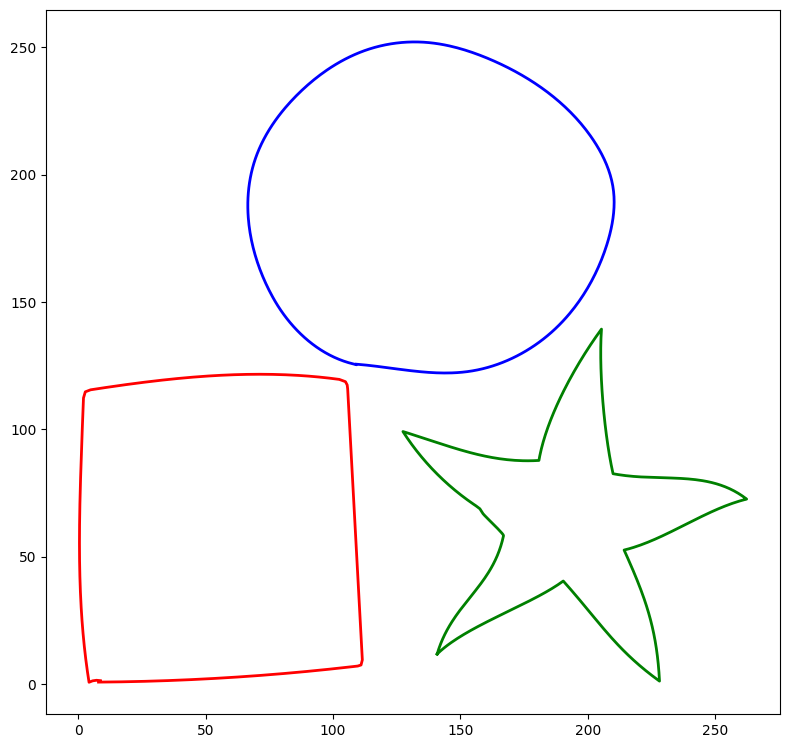

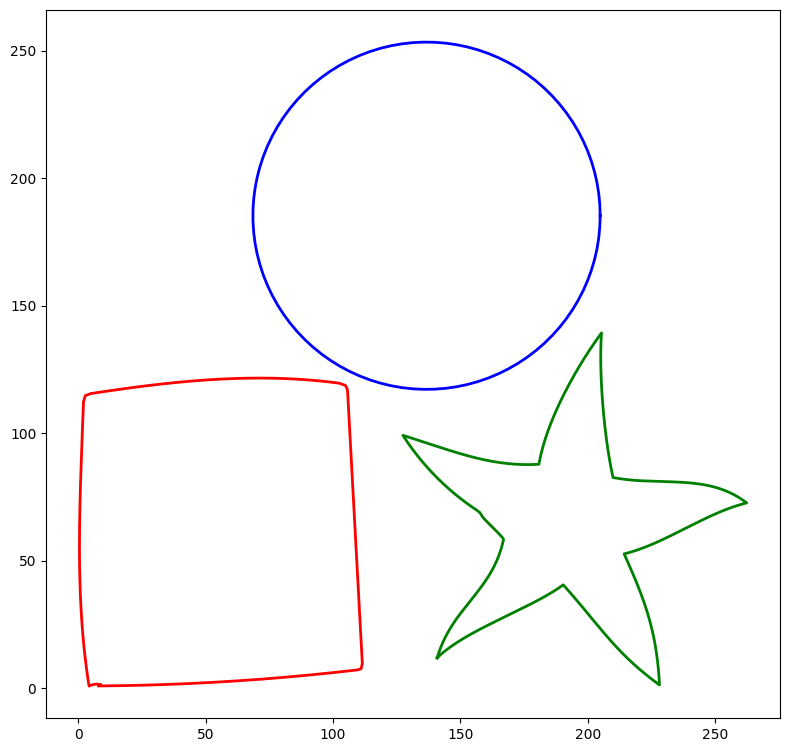

Symmetries found: ['Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet']
Processing /content/frag0.csv


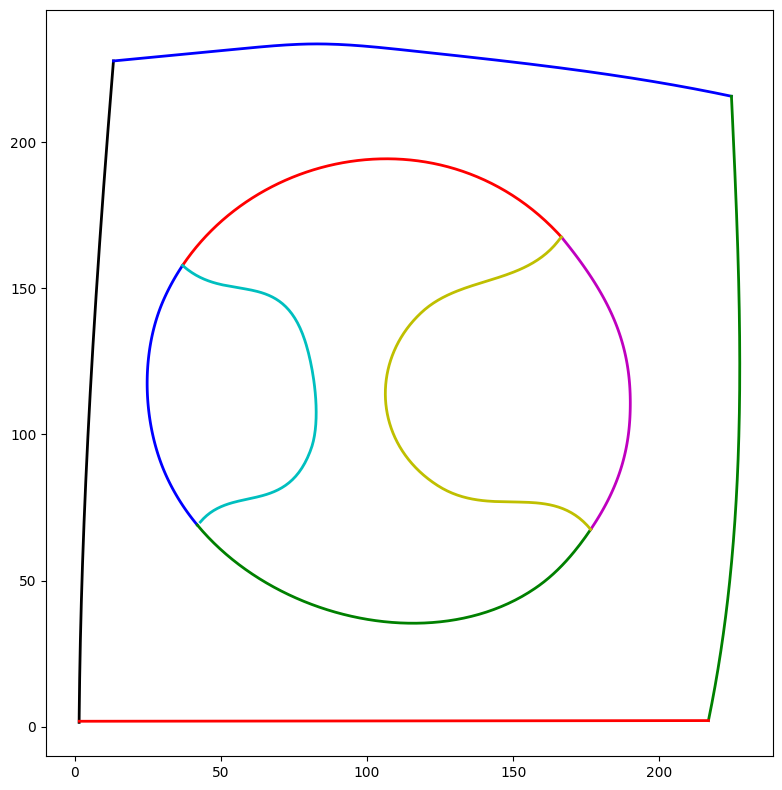

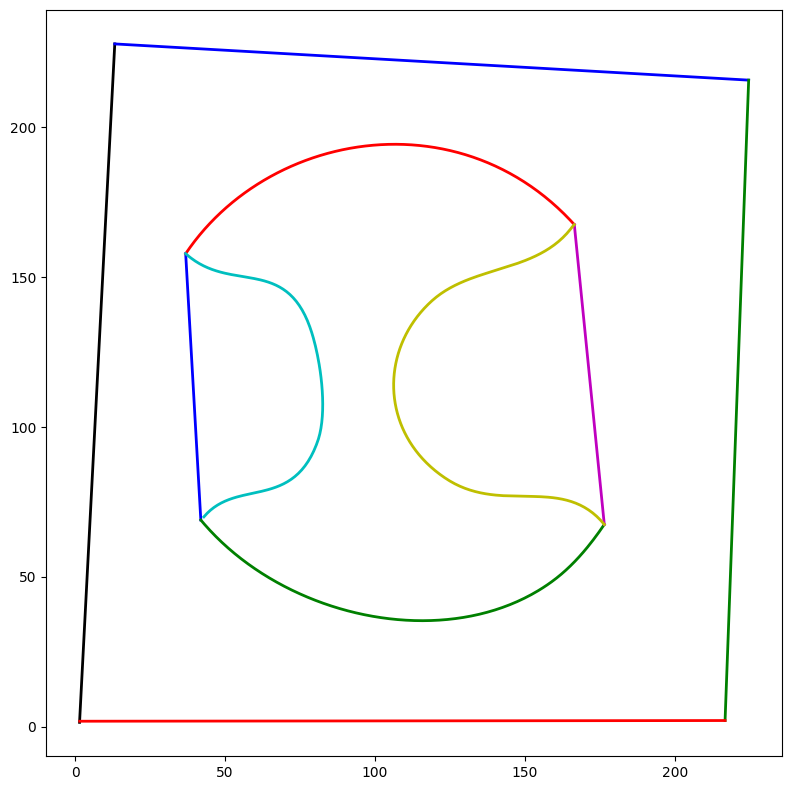

Symmetries found: ['Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet']
Processing /content/frag1.csv


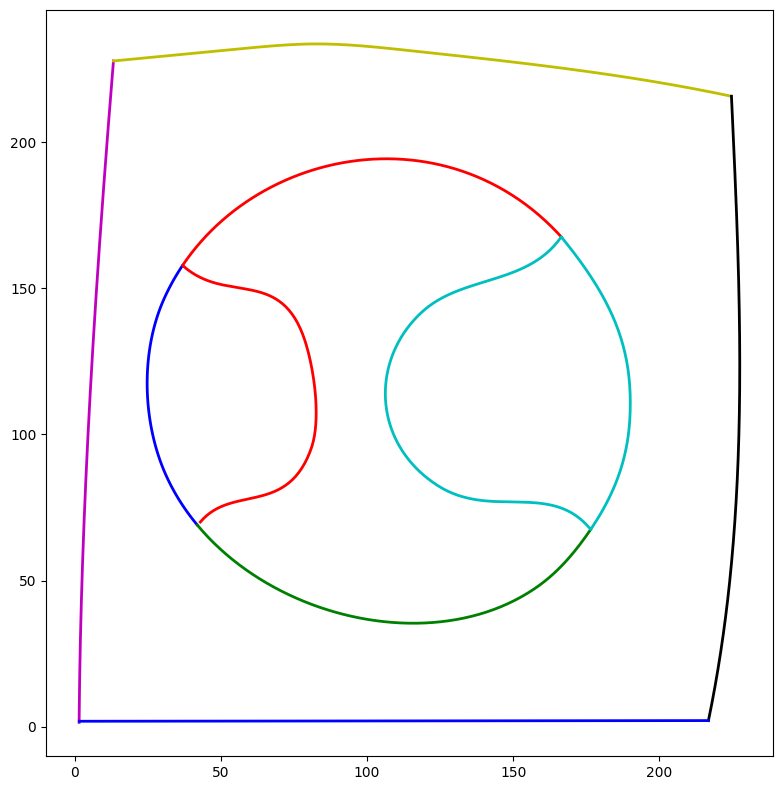

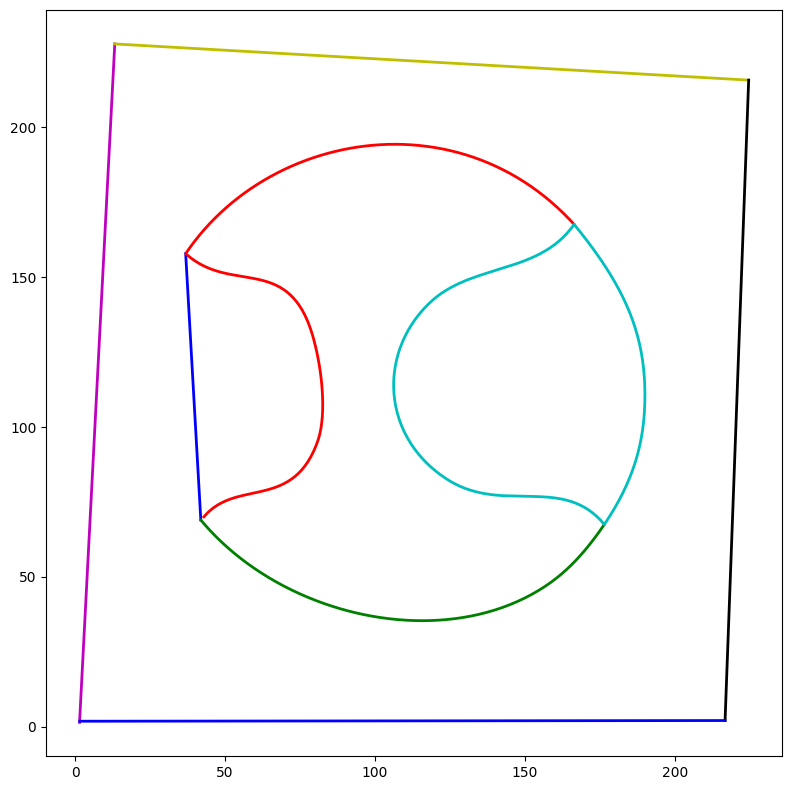

Symmetries found: ['Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet']
Processing /content/frag2.csv


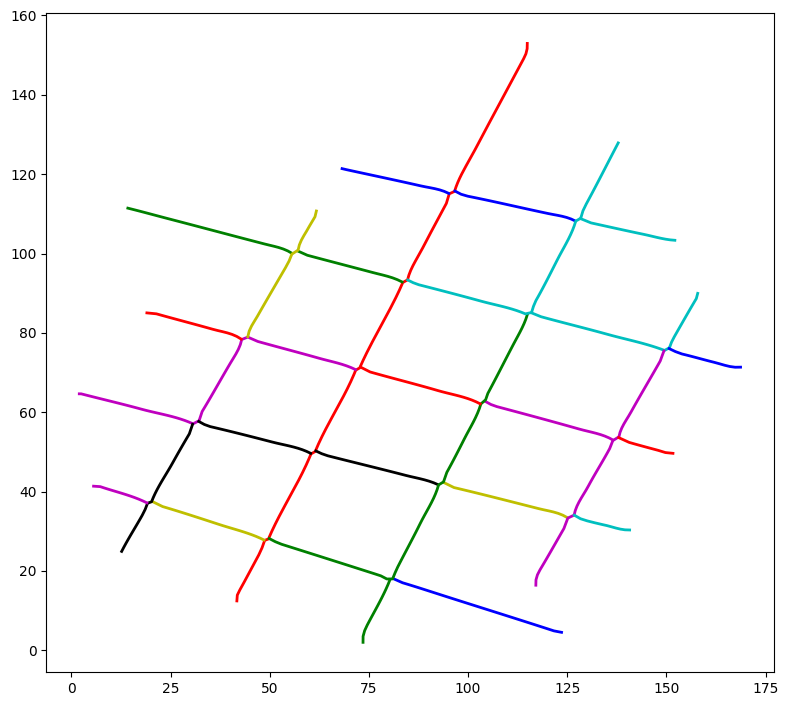

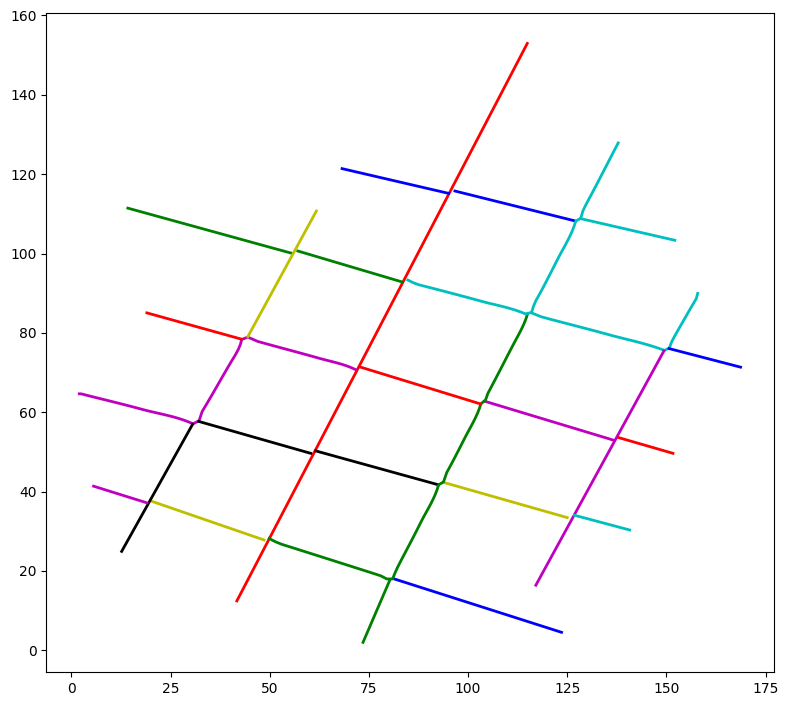

Symmetries found: ['Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet']
Processing /content/occlusion1.csv


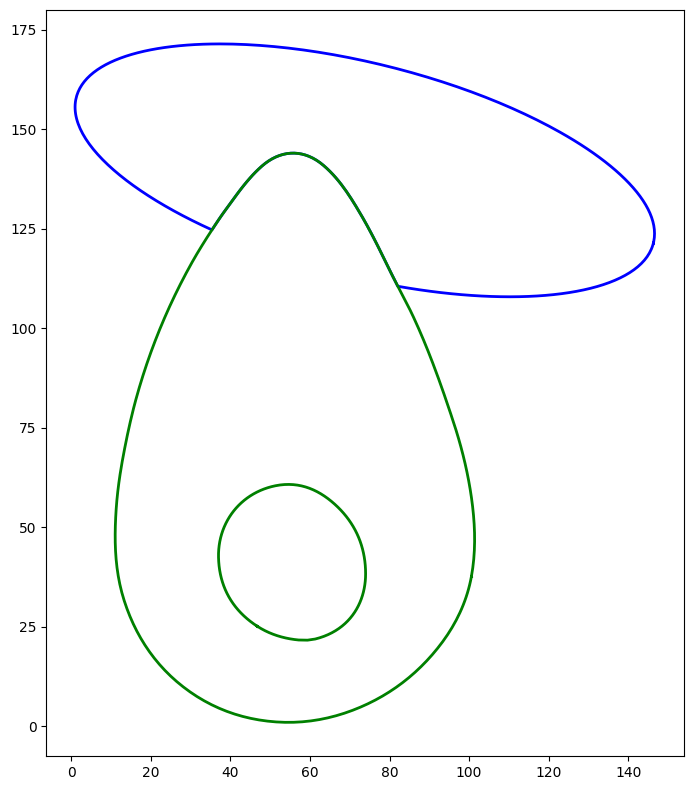

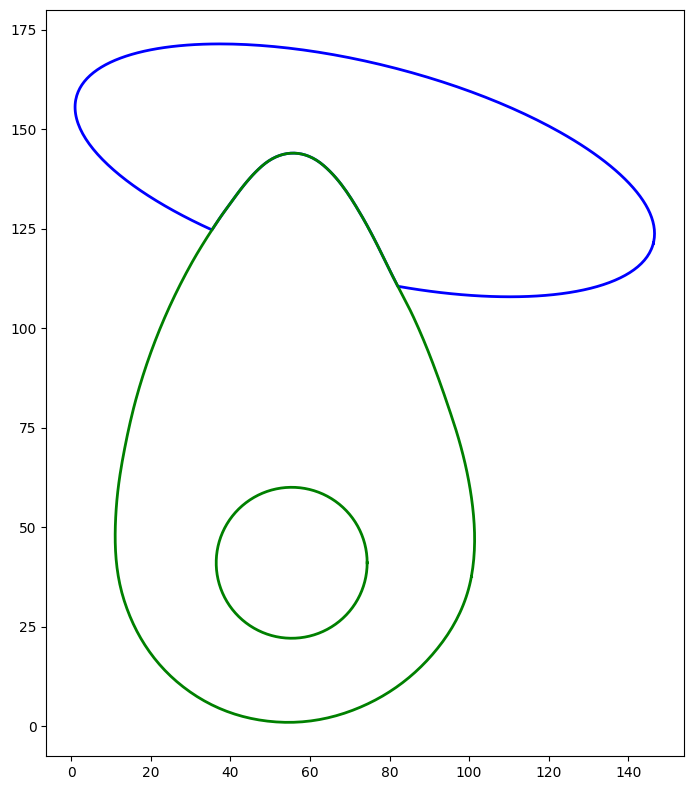

Symmetries found: ['Symmetry not implemented yet', 'Symmetry not implemented yet']
Processing /content/occlusion2.csv


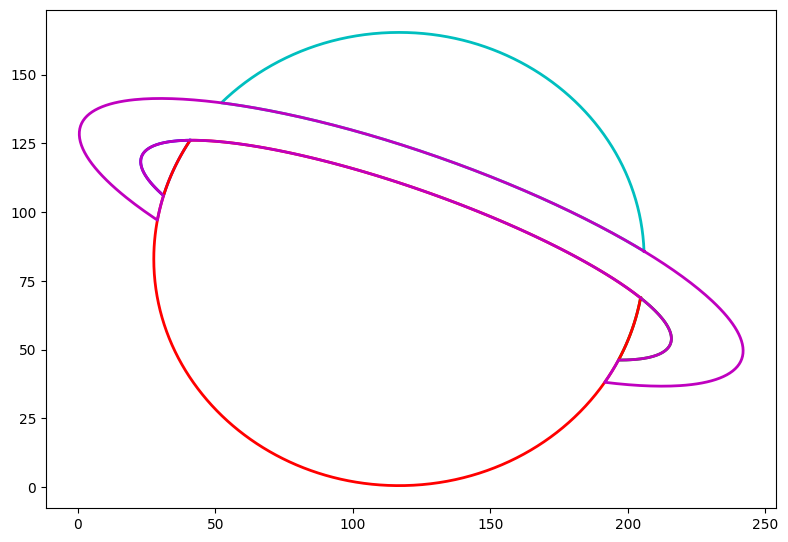

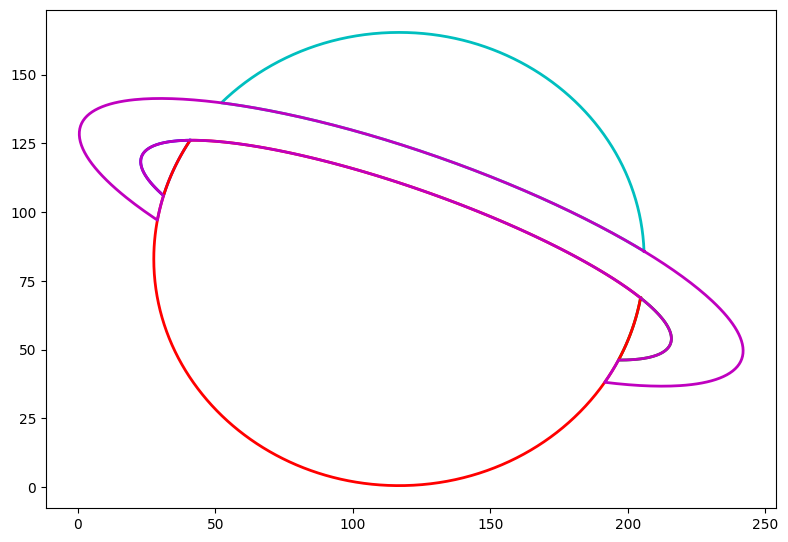

Symmetries found: ['Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet', 'Symmetry not implemented yet']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
from scipy.spatial.distance import cdist

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact*W, output_height=fact*H,
                     background_color='white')
    return

def is_straight_line(points, threshold=0.1):
    if len(points) < 3:
        return True
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    total_distance = np.sum(distances)
    end_to_end = np.sqrt(np.sum((points[-1] - points[0])**2))
    return (end_to_end / total_distance) > (1 - threshold)

def is_circle(points, threshold=0.1):
    if len(points) < 5:
        return False
    center = np.mean(points, axis=0)
    distances = cdist([center], points)[0]
    mean_distance = np.mean(distances)
    max_deviation = np.max(np.abs(distances - mean_distance))
    return max_deviation / mean_distance < threshold

def is_rectangle(points, threshold=0.1):
    if len(points) < 4:
        return False
    edges = np.roll(points, -1, axis=0) - points
    lengths = np.linalg.norm(edges, axis=1)
    for i in range(2):
        if not np.allclose(edges[i], -edges[i+2], atol=threshold) or \
           abs(lengths[i] - lengths[i+2]) / max(lengths[i], lengths[i+2]) > threshold:
            return False
    dot_products = np.sum(edges * np.roll(edges, -1, axis=0), axis=1)
    return np.allclose(dot_products, 0, atol=threshold * np.max(lengths)**2)

def regularize_shape(points):
    if is_straight_line(points):
        return np.array([points[0], points[-1]])
    elif is_circle(points):
        center = np.mean(points, axis=0)
        radius = np.mean(np.linalg.norm(points - center, axis=1))
        theta = np.linspace(0, 2*np.pi, 100)
        return np.column_stack([radius * np.cos(theta) + center[0],
                                radius * np.sin(theta) + center[1]])
    elif is_rectangle(points):
        hull = points[np.argpartition(np.sum(points**2, axis=1), -4)[-4:]]
        center = np.mean(hull, axis=0)
        angles = np.arctan2(hull[:, 1] - center[1], hull[:, 0] - center[0])
        hull = hull[np.argsort(angles)]
        width = np.linalg.norm(hull[1] - hull[0])
        height = np.linalg.norm(hull[2] - hull[1])
        angle = np.arctan2(hull[1, 1] - hull[0, 1], hull[1, 0] - hull[0, 0])
        rect = np.array([[0, 0], [width, 0], [width, height], [0, height]])
        rotation = np.array([[np.cos(angle), -np.sin(angle)],
                             [np.sin(angle), np.cos(angle)]])
        return np.dot(rect, rotation.T) + hull[0]
    else:
        return points

def find_symmetry(shape):
    # Implement symmetry detection here
    # For now, we'll just return a placeholder
    return "Symmetry not implemented yet"

def regularize_and_find_symmetry(paths_XYs):
    regularized = []
    symmetries = []
    for path in paths_XYs:
        reg_path = []
        for points in path:
            reg_points = regularize_shape(points)
            reg_path.append(reg_points)
        regularized.append(reg_path)
        symmetries.append(find_symmetry(reg_path))
    return regularized, symmetries

def process_file(input_file, output_file):
    # Read input
    paths_XYs = read_csv(input_file)

    # Plot original
    plot(paths_XYs)

    # Regularize and find symmetry
    regularized, symmetries = regularize_and_find_symmetry(paths_XYs)

    # Plot regularized
    plot(regularized)

    # Save as SVG and PNG
    polylines2svg(regularized, output_file)

    return regularized, symmetries

# Main execution
input_files = [
    '/content/isolated.csv',
    '/content/frag0.csv',
    '/content/frag1.csv',
    '/content/frag2.csv',
    '/content/occlusion1.csv',
    '/content/occlusion2.csv'
]

for input_file in input_files:
    output_file = input_file.replace('.csv', '_sol.svg')
    print(f"Processing {input_file}")
    regularized, symmetries = process_file(input_file, output_file)
    print(f"Symmetries found: {symmetries}")
    print("="*50)


Processing /content/frag0.csv


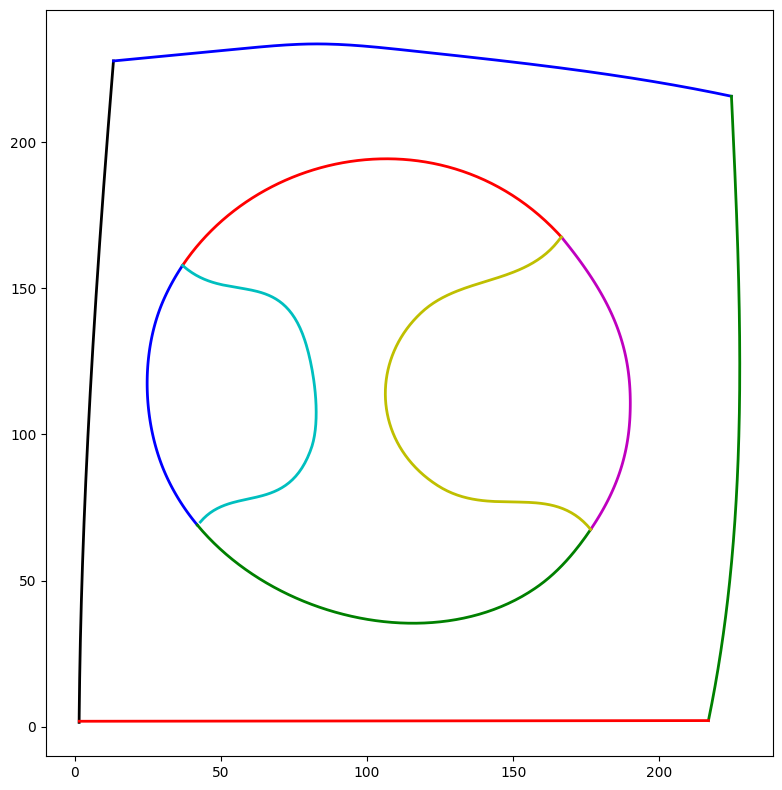

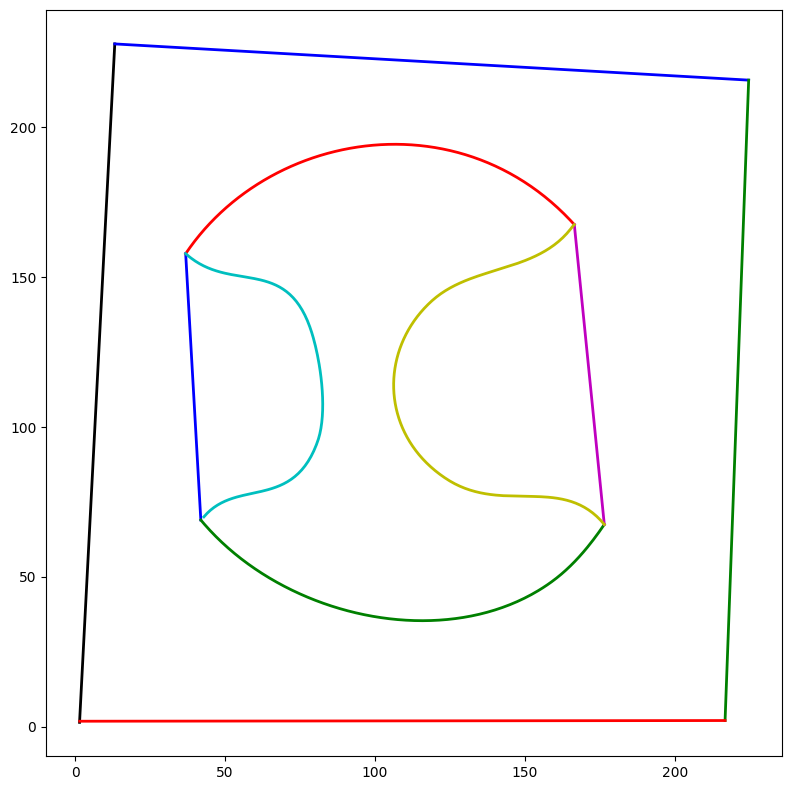

Symmetries found: ['No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected', 'No symmetry detected']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
from scipy.spatial.distance import cdist

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill=c, stroke='none', stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path,
                     parent_width=W, parent_height=H,
                     output_width=fact*W, output_height=fact*H,
                     background_color='white')
    return

def is_straight_line(points, threshold=0.1):
    if len(points) < 3:
        return True
    diffs = np.diff(points, axis=0)
    distances = np.sqrt(np.sum(diffs**2, axis=1))
    total_distance = np.sum(distances)
    end_to_end = np.sqrt(np.sum((points[-1] - points[0])**2))
    return (end_to_end / total_distance) > (1 - threshold)

def is_circle(points, threshold=0.1):
    if len(points) < 5:
        return False
    center = np.mean(points, axis=0)
    distances = cdist([center], points)[0]
    mean_distance = np.mean(distances)
    max_deviation = np.max(np.abs(distances - mean_distance))
    return max_deviation / mean_distance < threshold

def is_rectangle(points, threshold=0.1):
    if len(points) < 4:
        return False
    edges = np.roll(points, -1, axis=0) - points
    lengths = np.linalg.norm(edges, axis=1)
    for i in range(2):
        if not np.allclose(edges[i], -edges[i+2], atol=threshold) or \
           abs(lengths[i] - lengths[i+2]) / max(lengths[i], lengths[i+2]) > threshold:
            return False
    dot_products = np.sum(edges * np.roll(edges, -1, axis=0), axis=1)
    return np.allclose(dot_products, 0, atol=threshold * np.max(lengths)**2)

def regularize_shape(points):
    if is_straight_line(points):
        return np.array([points[0], points[-1]])
    elif is_circle(points):
        center = np.mean(points, axis=0)
        radius = np.mean(np.linalg.norm(points - center, axis=1))
        theta = np.linspace(0, 2*np.pi, 100)
        return np.column_stack([radius * np.cos(theta) + center[0],
                                radius * np.sin(theta) + center[1]])
    elif is_rectangle(points):
        hull = points[np.argpartition(np.sum(points**2, axis=1), -4)[-4:]]
        center = np.mean(hull, axis=0)
        angles = np.arctan2(hull[:, 1] - center[1], hull[:, 0] - center[0])
        hull = hull[np.argsort(angles)]
        width = np.linalg.norm(hull[1] - hull[0])
        height = np.linalg.norm(hull[2] - hull[1])
        angle = np.arctan2(hull[1, 1] - hull[0, 1], hull[1, 0] - hull[0, 0])
        rect = np.array([[0, 0], [width, 0], [width, height], [0, height]])
        rotation = np.array([[np.cos(angle), -np.sin(angle)],
                             [np.sin(angle), np.cos(angle)]])
        return np.dot(rect, rotation.T) + hull[0]
    else:
        return points

def find_symmetry(shape):
    # Check for symmetry along x-axis, y-axis, and diagonal
    symmetries = []

    # Symmetry about the x-axis
    if np.allclose(shape[:, 1], -shape[:, 1][::-1], atol=1e-2):
        symmetries.append("Symmetry about the x-axis")

    # Symmetry about the y-axis
    if np.allclose(shape[:, 0], -shape[:, 0][::-1], atol=1e-2):
        symmetries.append("Symmetry about the y-axis")

    # Symmetry about the line y = x
    if np.allclose(shape[:, 0], shape[:, 1][::-1], atol=1e-2):
        symmetries.append("Symmetry about the line y=x")

    # Symmetry about the line y = -x
    if np.allclose(shape[:, 0], -shape[:, 1][::-1], atol=1e-2):
        symmetries.append("Symmetry about the line y=-x")

    if not symmetries:
        return "No symmetry detected"
    return ", ".join(symmetries)

def regularize_and_find_symmetry(paths_XYs):
    regularized = []
    symmetries = []
    for path in paths_XYs:
        reg_path = []
        for points in path:
            reg_points = regularize_shape(points)
            reg_path.append(reg_points)
        regularized.append(reg_path)
        for shape in reg_path:
            symmetries.append(find_symmetry(shape))
    return regularized, symmetries

def process_file(input_file, output_file):
    # Read input
    paths_XYs = read_csv(input_file)

    # Plot original
    plot(paths_XYs)

    # Regularize and find symmetry
    regularized, symmetries = regularize_and_find_symmetry(paths_XYs)

    # Plot regularized
    plot(regularized)

    # Save as SVG and PNG
    polylines2svg(regularized, output_file)

    return regularized, symmetries

# Main execution
input_file = '/content/frag0.csv'  # Specify the frag0.csv file
output_file = input_file.replace('.csv', '_sol.svg')
print(f"Processing {input_file}")
regularized, symmetries = process_file(input_file, output_file)
print(f"Symmetries found: {symmetries}")


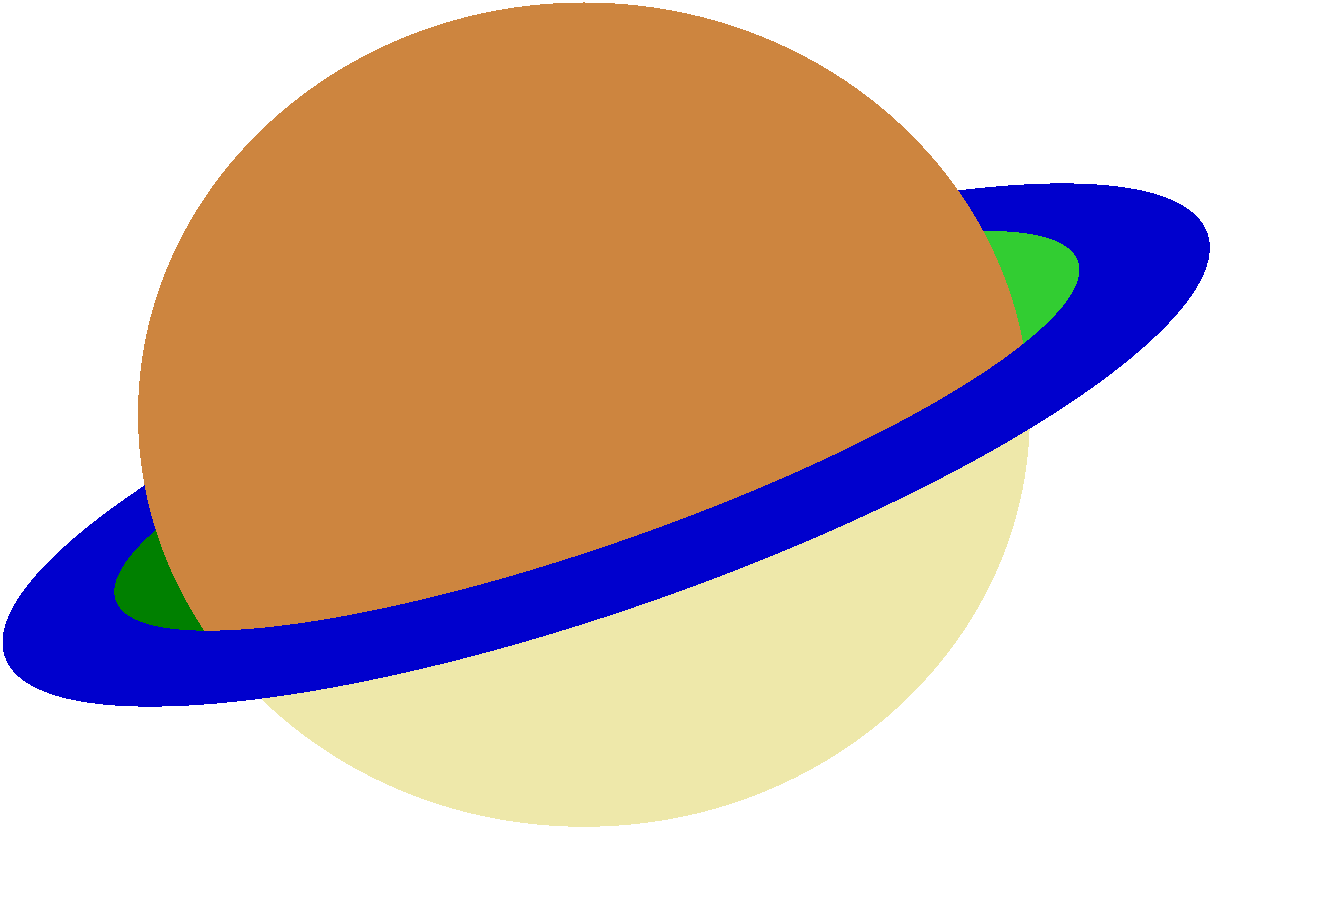

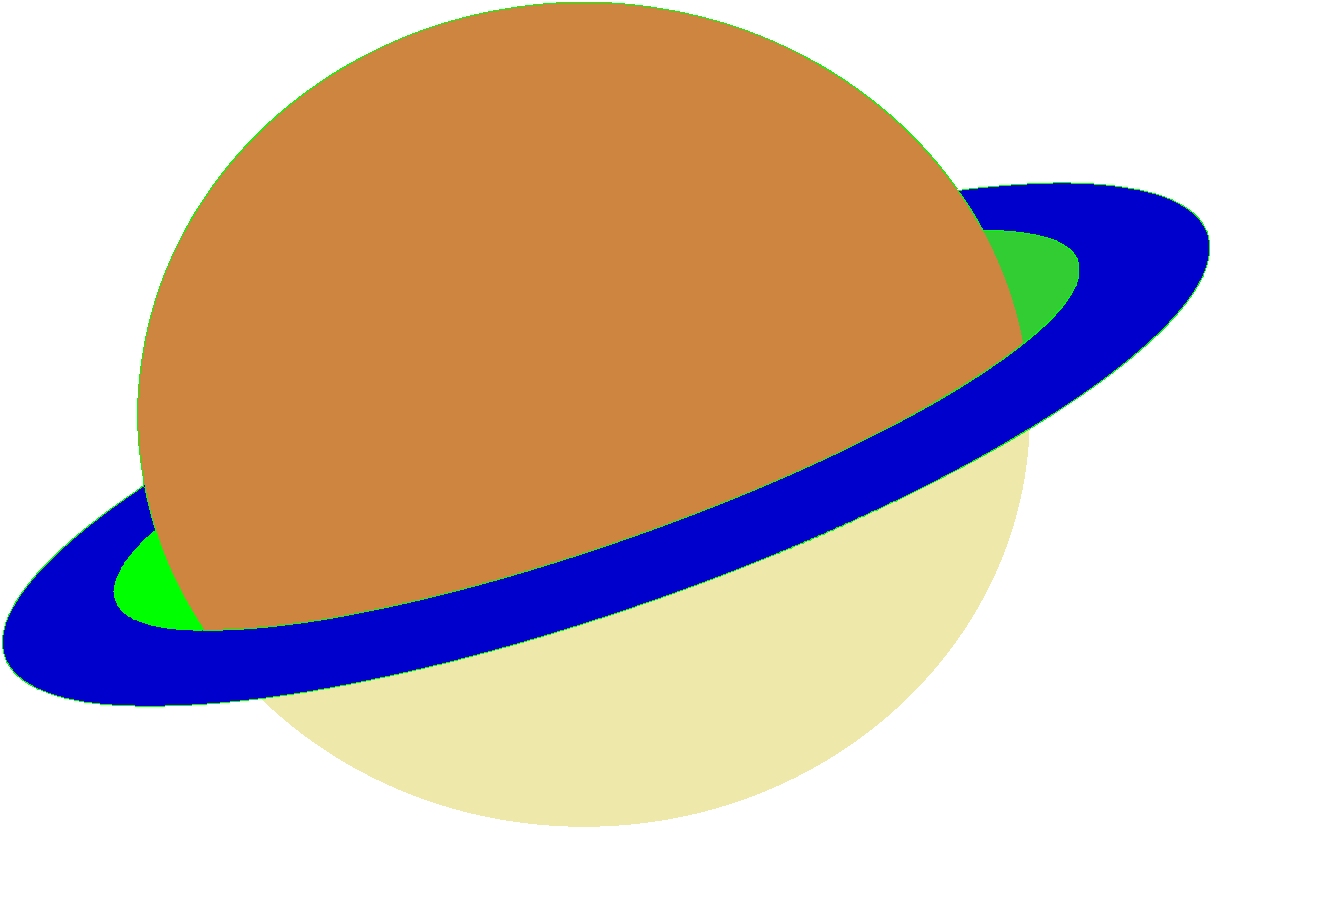

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the image from a PNG file
image_path = "/occlusion2_rec.png"  # Replace with your image path
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    raise ValueError(f"Failed to load the image. Check the file path: {image_path}")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to the grayscale image to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges using Canny
edges = cv2.Canny(blurred, 50, 150)

# Find contours based on the edges detected
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw and fill the contours
filled_img = img.copy()

# Iterate over each contour and fill it with a color (e.g., green)
for contour in contours:
    cv2.drawContours(filled_img, [contour], -1, (0, 255, 0), thickness=cv2.FILLED)

# Save the resulting image
output_path = "/filled_shapes.png"
cv2.imwrite(output_path, filled_img)

# Display the original and filled images
cv2_imshow(img)         # Original image
cv2_imshow(filled_img)  # Image with filled shapes
